<a href="https://colab.research.google.com/github/ling-zhang-linnet/two-stage-dcopf-neural-solver/blob/main/rld_118bus_(step2)proposed_learning_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# in case gpu is used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb  3 00:17:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions.multivariate_normal as tdm

root_path = './gdrive/MyDrive/Inbox/rld_neural_policy/'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# helper functions, can be folded

## utils.py

In [5]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")


# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
        Also return the distance vetor.
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return distance, np.mean(distance)

## plot.py

In [6]:
def plot_train_loss(train_hist, epoch, fig_name, yplot):
        print('len:', len(train_hist['train_losses']))

        fig = plt.figure(figsize=(10,10))
        plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
        ax = fig.add_subplot(1, 1, 1)
        if yplot == 'log10':
            ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
            ax.set_ylabel('log10(train loss)',fontsize=20)
        elif yplot == 'plain':
            ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
            ax.set_ylabel('train loss',fontsize=20)
        ax.set_xlabel('training epochs',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(model_path+str(epoch)+fig_name)

## models.py

In [7]:
class ActionNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ActionNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, D_out)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)


    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """

        x = F.relu(self.linear1(input))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = self.dropout(x)
        x = F.relu(self.linear4(x))
        x = self.dropout(x)
        y_pred = F.relu(self.linear5(x))


        return y_pred


# class RewardNet(torch.nn.Module):
#     def __init__(self, D_in, H, D_out):
#         """
#         In the constructor we instantiate two nn.Linear modules and assign them as
#         member variables.
#         """
#         super(RewardNet, self).__init__()
#         # x = torch.randn(batch_size=32, inchannels=3, imag_rows=128, img_cols=128)
#         # x = torch.randn(100, 2, 11, 11)
#         # so you have to represent the 118-dimensional vector as 11 by 11 matrix
#         # one channel for l-x, and the other channel for x-l
#         # conv2 = nn.Conv2d(in_channels=3,
#         #           out_channels=7,
#         #           kernel_size=5,
#         #           padding=2)
#         # y = conv2(x)
#         # torch.nn.Conv1d(
#         #                 in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
#         #                 )
#         self.C_in = 1
#         self.C_out = 1
#         self.k_size = 4
#         self.stride = 2
#         self.padding = 0
#         self.L = D_in
#         self.fc_in =  int( (self.L - self.k_size + 2*self.padding)/2+1 )

#         self.conv = torch.nn.Conv1d(in_channels=self.C_in, out_channels=self.C_out, 
#                                     kernel_size=self.k_size, stride=self.stride, 
#                                     padding=self.padding)

#         self.fc1 = torch.nn.Linear(self.fc_in, H)
#         self.fc2 = torch.nn.Linear(H, H)
#         self.fc3 = torch.nn.Linear(H, H)
#         self.fc4 = torch.nn.Linear(H, H)
#         self.fc5 = torch.nn.Linear(H, D_out)

#     def forward(self, input):
#         """
#         In the forward function we accept a Tensor of input data and we must return
#         a Tensor of output data. We can use Modules defined in the constructor as
#         well as arbitrary operators on Tensors.
#         """
#         # Returns a new tensor with a dimension of size one 
#         # inserted at the specified position.
#         x = x.unsqueeze(1)

#         x = F.relu(self.conv(x))
#         x = torch.flatten(x, start_dim=1, end_dim=-1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         y_pred = torch.tanh(self.fc5(x))


#         return y_pred


class TrainDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    # must override two of the subclass functions:
    def __len__(self):
        # return len(self.samples)
        return self.samples.shape[0]

    def __getitem__(self, idx):
        # return self.samples[idx]
        return self.samples[idx,:]


def init_weights(m):
    if isinstance(m, nn.Linear):

        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0.001)
        # m.bias.data.uniform_(0, y)

        # torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

        # How to call this function:
        # net.apply(init_weights)

### Conv1d

In [8]:
class RewardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(RewardNet, self).__init__()

        self.C_in = 1
        self.C_out = 8
        self.C_in2 = 8
        self.C_out2 = 16
        self.fc_in =  int(16*30)

        self.model = nn.Sequential(
                nn.Conv1d(self.C_in, self.C_out, kernel_size=4, 
                          stride=2, padding=0),
                # nn.MaxPool1d(2),

                torch.nn.ReLU(),

                nn.Conv1d(self.C_in2, self.C_out2, kernel_size=3, 
                            stride=4, padding=1),
                # nn.MaxPool1d(2),

                # nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
                # nn.MaxPool1d(2),

            )

        # self.linear = nn.Sequential(
        #         torch.nn.Linear(self.fc_in, H),
        #         torch.nn.ReLU(),
        #         torch.nn.Linear(H, H),
        #         torch.nn.ReLU(),
        #         # torch.nn.Linear(H, H),
        #         # torch.nn.ReLU(),
        #         # torch.nn.Linear(H, H),
        #         # torch.nn.ReLU(),
        #         torch.nn.Linear(H, D_out),
        #     )

        self.linear = nn.Sequential(
                torch.nn.Linear(self.fc_in, H),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                # torch.nn.Linear(H, H),
                # torch.nn.ReLU(),
                # torch.nn.Linear(H, H),
                # torch.nn.ReLU(),
                torch.nn.Linear(H, D_out),
            )

    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Returns a new tensor with a dimension of size one 
        # inserted at the specified position.
        x = input.unsqueeze(1)
        # print('x:', x.shape)

        x = F.relu(self.model(x))
        # print('x:', x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=-1) # flatten all dimensions except batch
        # print('x:', x.shape)
        y_pred = torch.tanh(self.linear(x))

        return y_pred


## gauge.py

In [9]:
def gauge_function(V, G, H):
    """
    The gauge function of the vector z w.r.t. the set P
    is given by the following code.

    V can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    
    """
    # return torch.max(G@V/H,dim = 0).values # shape(output) = (1, K)

    # torch.div() for element-wide division
    return torch.max(torch.div(G@V, H),dim = 0).values # shape(output) = (1, K)

def gauge_map(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the set P
    defined by {v: G@v <= h} is given by the following code.
    
    Z can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    """

    gamma_dest = gauge_function(Z, G, H)# shape = (1, K)
    # print('gamma_dest:', gamma_dest)
    gamma_start = torch.linalg.norm(Z, ord = np.inf, dim=0) # shape(1, K)

    scaling_mat = torch.diag(gamma_start/gamma_dest) # shape = (K, K)

    return Z@scaling_mat # shape = (r, K), this is the new point in P

## paths.py




In [10]:
def get_paths():
    params_path = root_path+'118bus/params/'
    data_path = root_path+'118bus/data/'
    model_path = root_path+'118bus/saved_models_cnn2/'
    saved_path = root_path+'118bus/predictions_cnn2/'

    isExist = os.path.exists(model_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(model_path)

    isExist = os.path.exists(saved_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(saved_path)

    return params_path, data_path, saved_path, model_path

In [11]:
def load_saved_models(model_path, N_h1, N_h2):

    action_net = ActionNet(N, N_h1, N)
    action_net.load_state_dict(torch.load(model_path+'trained_action_net.pt'))

    reward_net = RewardNet(N, N_h2, N-1)
    reward_net.load_state_dict(torch.load(model_path+'trained_reward_net.pt'))

    return action_net, reward_net


def load_pretrain_models(model_path, N_h1, N_h2):

    action_net = ActionNet(N, N_h1, N)
    action_net.load_state_dict(torch.load(model_path+'pretrain_action_net.pt'))

    reward_net = RewardNet(N, N_h2, N-1)
    reward_net.load_state_dict(torch.load(model_path+'pretrain_reward_net.pt'))

    return action_net, reward_net


def load_cost_coeff(params_path):    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff

## system.py

In [12]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2


def get_Y(N, B):
    # N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]


def get_A(N, L, B, connections):
    # N = num_buses
    # L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


# Import 118bus
def import_118bus(params_path):
    bus_data_fname = '118bus_BusData.csv'
    gen_data_fname = '118bus_GenData.csv'

    branch_data_fname = '118bus_BranchData.csv'
    cost_data_fname = '118bus_CostData.csv'

    bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
    gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
    branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
    cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)


    num_buses = bus_data_df.shape[0]
    num_lines = branch_data_df.shape[0]
    num_gens = gen_data_df.shape[0]


    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()
    cost_data = cost_data_df.to_numpy()

    x = branch_data[:,3]
    print('max of x:', max(x))
    print('min of x:', min(x))


    b = 1/x
    Z0 = 10
    b = b/Z0
    print('max of b:', max(b))
    print('min of b:', min(b))

    connections = []
    branches = branch_data[:,:2]
    for i in range(branches.shape[0]):
            connections.append([int(branches[i,0]),int(branches[i,1])])
    print('len of connections:', len(connections))

    unique_lines, set1, set2 = identify_unique_lines(connections)

    B = np.zeros((num_buses, num_buses))
    for k, line in unique_lines.items():
        row = line[0]-1
        col = line[1]-1
        B[row, col] = b[k]
        B[col, row] = b[k]

    PD = bus_data[:,2]/20
    print('Total PD:', sum(PD))

    return num_buses, num_lines, B, connections, PD

### import B, F and cost

In [13]:
params_path, data_path, saved_path, model_path = get_paths()

num_buses, num_lines, B, connections, PD_data = import_118bus(params_path)

N = num_buses
L = num_lines 

Yrr = get_Y(num_buses, B)
Arr = get_A(num_buses, num_lines, B, connections)

# Define feasibility set for gauge mapping
G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

# Load cost coefficients
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff(params_path) 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)
da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)

c = da_cost_Coeff
q = linear_cost_Coeff

max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
Total PD: 212.10000000000005
G shape: (606, 117)
quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


### set Fmax and std

In [14]:
Fmax = 1.5
input_std = 0.1
sce_std = 0.05

## eval.py

In [15]:
def evaluate_Q(forecast, x, num_sce):
    '''
    Given a single instance and the initial dispatch x, and evaluate the quality
    of x.
    This function can be applied to the decision obtained from any policy.
    '''

    M = num_sce

    theta = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):

        net_d = scenarios[:,m:m+1] - x

        constraints_list.append( y[:,m:m+1] == Yrr@theta[:,m:m+1] + net_d )
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)

    Q_vals = []
    for m in range(M):

        Q_vals.append(cp.pos(y[:,m:m+1].T)@q)

    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return prob.value, np.sum(y.value, axis=1)/M


def evaluate_outer_loop(forecasts, x_pred, num_sce):
    '''
    Given a batch of instances and the associated predictions of first stage decision,
    and evaluate these initial dispatch decisions for each instance.

    '''

    num_points = forecasts.shape[0]

    Q_pred = []
    y_pred = []

    for i in range(num_points):
        forecast = forecasts[i,:].reshape(-1,1)
        init_dispatch = x_pred[i,:].reshape(-1,1)

        Q_value, avg_y_value = evaluate_Q(forecast, init_dispatch, num_sce)

        Q_pred.append(Q_value)
        y_pred.append(avg_y_value.flatten())
        

    Q_pred = np.array(Q_pred).reshape(-1,1)
    y_pred = np.array(y_pred)

    total_cost_pred = x_pred@da_cost_Coeff + Q_pred

    return total_cost_pred, Q_pred, y_pred

# load.py

In [16]:
nominal_PD_data = PD_data.reshape(1,-1)

# Load dataset
train_dataset = np.load(data_path+'train_set.npy')
test_dataset = np.load(data_path+'test_set.npy')
pretrain_dataset = np.load(data_path+'pretrain_set.npy')

Ntr = train_dataset.shape[0]
Ntr2 = pretrain_dataset.shape[0]
Ntst = test_dataset.shape[0]


max_PD_tr = np.max(train_dataset)
# Note that the original train_dataset and test_dataset are not normalized
TrainSet = TrainDataset(train_dataset/max_PD_tr)
TestSet = TrainDataset(test_dataset/max_PD_tr)


In [17]:
# TrainSet = TrainDataset(train_dataset[:100,:]/max_PD_tr)

# pretrain.py

In [ ]:
# Format:
# X_train, X_test: [forecasts, x_true]
# X_train2, X_test2:[forecasts-x_true, theta_true, y_true, Q_true]

X_train = np.load(data_path+'X_train.npy')
X_test = np.load(data_path+'X_test.npy')
X_train2 = np.load(data_path+'X_train2.npy')
X_test2 = np.load(data_path+'X_test2.npy')

assert Ntr2 == X_train.shape[0]+X_test.shape[0]
assert Ntr2 == X_train2.shape[0]+X_test2.shape[0]

In [ ]:
print('X_train2:', X_train2.shape)
print('X_test2:', X_test2.shape)

# X_train3 = np.concatenate([X_train2[:,:N], -X_train2[:,:N]], axis=-1 )
# X_test3 = np.concatenate([X_test2[:,:N], -X_test2[:,:N]], axis=-1 )
NetD1 = np.clip(X_train2[:,:N], a_min=0., a_max=None)
NetD2 = np.clip(-X_train2[:,:N], a_min=0., a_max=None)
X_train3 = np.concatenate([NetD1, -NetD2], axis=-1 )

NetD1 = np.clip(X_test2[:,:N], a_min=0., a_max=None)
NetD2 = np.clip(-X_test2[:,:N], a_min=0., a_max=None)
X_test3 = np.concatenate([NetD1, -NetD2], axis=-1 )


y_train3 = X_train2[:,N:]
y_test3 = X_test2[:,N:]

X_train3 = np.concatenate([X_train3, y_train3], axis=-1)
X_test3 = np.concatenate([X_test3, y_test3], axis=-1)

print('X_train3:', X_train3.shape)
print('X_test3:', X_test3.shape)

X_train2: (90, 354)
X_test2: (10, 354)
X_train3: (90, 472)
X_test3: (10, 472)


## pretrain action net

In [ ]:
def train_action_net(dataset, num_epochs, batch_size, N_h, yplot = 'plain'):

    # Set learning rates
    lr = 1e-5

    # Build models or load models
    # action_net, reward_net = load_saved_models()
    action_net = ActionNet(N, N_h, N)
    action_net.apply(init_weights)

    # Configure optimizers
    # action_optim = optim.Adam(action_net.parameters(), lr=lr, weight_decay=1e-2)
    action_optim = optim.Adam(action_net.parameters(), lr=lr, betas=(0.5, 0.999))

    loss_criterion = nn.MSELoss()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

            ## zero grad
            action_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            load = input[:, :N]
            target = input[:, N:]

            x_pred = action_net(load)

            train_loss = loss_criterion(x_pred, target)

            train_loss.backward(retain_graph=True)
            action_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 2000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                    
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time/60)
                
        if epoch > 0 :
            if epoch % 20000 == 0 or epoch == num_epochs-1:

                torch.save(action_net.state_dict(), model_path+'pretrain_action_net.pt')

                plot_train_loss(train_hist, epoch, 'pretrain_action_loss.png', yplot)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f minutes, total %d epochs time: %.2f minutes" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time/60))
    print("Training finish!")

    return action_net


### call

In [ ]:
# pretrain_action_net = train_action_net(TrainDataset(X_train), num_epochs=1000, 
#                                    batch_size=1, N_h = 256, yplot = 'log10')

### evaliate pretrained action net

In [ ]:
# # Load neural solutions
# # x_nu = np.load(data_path+'x_nu.npy')

# # otherwise
# # Load saved models from model_path or saved_path

# def eval_pretrain_action_net(net, dataset):
#     net.eval()

#     with torch.no_grad():

#         input = torch.tensor(dataset/max_PD_tr).float()
#         start_time = time.time()

#         output = net(input)

#         print("--- %s minutes ---" % ((time.time() - start_time)/60))

#         output_val = output.detach().numpy()

#         x_pred = output_val*max_PD_tr

#     return x_pred

In [ ]:
# x_pred = eval_pretrain_action_net(pretrain_action_net, X_test[:,:N]*max_PD_tr)
# print('x_pred:', x_pred.shape)

In [ ]:
# x_true = X_test[:,N:]*max_PD_tr
# print('x_true:', x_true.shape)

In [ ]:
# fig, ax0 = plt.subplots(figsize=(60,10))
# Xrange = np.array(range(N))

# N_points = X_test.shape[0]

# for i in range(N_points):
#     if i == 0:
#         ax0.plot(Xrange, x_pred[i,:], 'y-D', markersize=10, linewidth=2, label='pretrain')
#         ax0.plot(Xrange, x_true[i,:], 'r--', markersize=10, linewidth=2, label='true')

#     else:
#         ax0.plot(Xrange, x_pred[i,:], 'y-D', markersize=10, linewidth=2)
#         ax0.plot(Xrange, x_true[i,:], 'r--', markersize=10, linewidth=2)

# # ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24, loc='best')
# ax0.tick_params(axis='x', labelsize=24 )
# ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# # ax0.set_ylabel('total power', fontsize=24 )
# ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
#               fontsize=32, color='k')

# ax1 = ax0.twinx()
# ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
# ax1.tick_params(axis='y', labelsize=24 )
# ax1.set_ylabel('price', fontsize=24, rotation=90 )
# ax1.legend(fontsize=24, loc='upper left')


# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,5))

# n_bins = 20
# axs[0].hist(np.sum(x_true, axis=-1), bins=n_bins, density=True)

# axs[0].tick_params(axis='x', labelsize=24 )
# axs[0].tick_params(axis='y', labelsize=24 )
# # ax0.set_xlabel('Buses', fontsize=24 )
# # ax0.set_ylabel('total power', fontsize=24 )
# axs[0].set_title(r'sum over x (true)', fontsize=24, color='k' )

# axs[1].hist(np.sum(x_pred, axis=-1), bins=n_bins, density=True)
# axs[1].tick_params(axis='x', labelsize=24 )
# axs[1].set_title(r'sum over x (pretrain)', fontsize=24, color='k' )
# plt.show()



## pretrain reward net

In [ ]:
def train_reward_net(dataset, num_epochs, batch_size, N_h, yplot = 'plain'):

    # Set learning rates
    lr = 1e-4

    # Build models or load models
    # action_net, reward_net = load_saved_models()
    reward_net = RewardNet(N, N_h, N-1)
    reward_net = reward_net.to(device)
    
    # Configure optimizers
    reward_optim = optim.Adam(reward_net.parameters(), lr=lr, betas=(0.5, 0.999))

    loss_criterion = nn.MSELoss()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    G_ts = torch.tensor(G).float().to(device)
    B_ts = torch.tensor(-Yrr).float().to(device)
    F_ts = torch.tensor(Arr).float().to(device)
    q_ts = torch.tensor(linear_cost_Coeff).float().to(device)
    c_ts = torch.tensor(da_cost_Coeff).float().to(device)

    h_batch = torch.cat([
                    Fmax*torch.ones(L, batch_size),
                    Fmax*torch.ones(L, batch_size),
                    np.pi*torch.ones(N-1, batch_size),
                    np.pi*torch.ones(N-1, batch_size)
                    ],dim=0)

    h_batch_ts = torch.tensor(h_batch).float().to(device)
    
    ctr_ts = torch.zeros((N-1, batch_size)).to(device)
    assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

    # Use ctr_ts to shift the feasible set Gv<=H
    h_shift = h_batch_ts - G_ts@ctr_ts
    assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"


    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

            ## zero grad
            reward_net.zero_grad()

            ## get a batch of data
            input = batch.float().to(device)
            D_in = N+N
            q_input = input[:, :D_in]
            target = input[:, D_in:D_in+N-1]
            y_target = input[:, D_in+N-1:D_in+N-1+N]
            Q_target = input[:, D_in+N-1+N:]

            pred = reward_net(q_input)

            # net_d = q_input*max_val
            net_d = input[:, :N]+input[:, N:N+N]

            # Use gauge mapping to transform output to feas_output
            feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

            y_pred = -B_ts@feas_pred + net_d.T # (N, batch_size)
            Q_pred = F.relu(y_pred.T)@q_ts

            train_loss = loss_criterion(feas_pred.T, target)

            train_loss.backward(retain_graph=True)
            reward_optim.step()

            train_losses.append(train_loss.item())

            num_iter += 1

            if num_iter % 10000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                    
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time/60)
                
        if epoch > 0 :
            if epoch % 100000 == 0 or epoch == num_epochs-1:

                torch.save(reward_net.state_dict(), model_path+'pretrain_reward_net.pt')

                plot_train_loss(train_hist, epoch, 'pretrain_reward_loss.png', yplot)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f minutes, total %d epochs time: %.2f minutes" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time/60))
    print("Training finish!")

    return reward_net


### call

In [ ]:
# pretrain_reward_net = train_reward_net(TrainDataset(X_train3), num_epochs=1500, 
#                                    batch_size=1, N_h=256, yplot = 'log10')

### evaluate pretrained reward net

In [ ]:
# Load neural solutions
# x_nu = np.load(data_path+'x_nu.npy')

# otherwise
# Load saved models from model_path or saved_path

def eval_pretrain_reward_net(net, dataset):
    net.eval()

    with torch.no_grad():

        G_ts = torch.tensor(G).float().to(device)
        B_ts = torch.tensor(-Yrr).float().to(device)
        q_ts = torch.tensor(linear_cost_Coeff).float().to(device)

        input = torch.tensor(dataset).float().to(device)
        q_input = input[:,:N+N]
        net_d = input[:, :N]+input[:, N:N+N]

        h_batch = torch.cat([
                            Fmax*torch.ones(L, input.shape[0]),
                            Fmax*torch.ones(L, input.shape[0]),
                            np.pi*torch.ones(N-1, input.shape[0]),
                            np.pi*torch.ones(N-1, input.shape[0])
                            ],dim=0)

        h_batch_ts = torch.tensor(h_batch).float().to(device)
        
        ctr_ts = torch.zeros((N-1, input.shape[0])).to(device)
        assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

        # Use ctr_ts to shift the feasible set Gv<=H
        h_shift = h_batch_ts - G_ts@ctr_ts
        assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

        # start feedforwad
        start_time = time.time()
        
        output = net(q_input)
        
        # Use gauge mapping to transform output to feas_output
        theta_pred = gauge_map(output.T, G_ts, h_shift) + ctr_ts

        y_pred = -B_ts@theta_pred + net_d.T # (N, batch_size)
        Q_pred = F.relu(y_pred).T@q_ts

        print("--- %s minutes ---" % ((time.time() - start_time)/60))


        return theta_pred.cpu().detach().numpy().T, y_pred.cpu().detach().numpy().T, Q_pred.cpu().detach().numpy()

In [ ]:
# theta_pred, y_pred, Q_pred = eval_pretrain_reward_net(pretrain_reward_net, X_test3[:,:N+N])
# print('theta_pred:', theta_pred.shape)
# print('y_pred:', y_pred.shape)
# print('Q_pred:', Q_pred.shape)

In [ ]:
# theta_true = X_test2[:,N:N+N-1]
# y_true = X_test2[:,N+N-1:N+N-1+N]
# Q_true = X_test2[:,N+N-1+N:]
# print('theta_true:', theta_true.shape)
# print('y_true:', y_true.shape)
# print('Q_true:', Q_true.shape)

In [ ]:
# fig, ax0 = plt.subplots(figsize=(60,10))
# Xrange = np.array(range(N-1))

# N_points = X_test2.shape[0]

# for i in range(N_points):
#     if i == 0:
        
#         ax0.plot(Xrange, theta_true[i,:], 'y-D', markersize=10, linewidth=2, label='true')
#         ax0.plot(Xrange, theta_pred[i,:], 'b--', markersize=10, linewidth=2, label='pretrain')

#     else:

#         ax0.plot(Xrange, theta_true[i,:], 'y-D', markersize=10, linewidth=2)
#         ax0.plot(Xrange, theta_pred[i,:], 'b--', markersize=10, linewidth=2)

# # ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24, loc='best')
# ax0.tick_params(axis='x', labelsize=24 )
# ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# # ax0.set_ylabel('total power', fontsize=24 )
# ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
#               fontsize=32, color='k')

# # ax1 = ax0.twinx()
# # ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
# # ax1.tick_params(axis='y', labelsize=24 )
# # ax1.set_ylabel('price', fontsize=24, rotation=90 )
# # ax1.legend(fontsize=24, loc='upper left')


# plt.show()

In [ ]:
# fig, ax0 = plt.subplots(figsize=(60,10))
# Xrange = np.array(range(N))

# N_points = X_test2.shape[0]

# for i in range(N_points):
#     if i == 0:
        
#         ax0.plot(Xrange, y_pred[i,:], 'b--', markersize=10, linewidth=2, label='pretrain')
#         ax0.plot(Xrange, y_true[i,:], 'y-D', markersize=10, linewidth=2, label='true')

#     else:

#         ax0.plot(Xrange, y_pred[i,:], 'b--', markersize=10, linewidth=2)
#         ax0.plot(Xrange, y_true[i,:], 'y-D', markersize=10, linewidth=2)

# # ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24, loc='best')
# ax0.tick_params(axis='x', labelsize=24 )
# ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# # ax0.set_ylabel('total power', fontsize=24 )
# ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
#               fontsize=32, color='k')

# # ax1 = ax0.twinx()
# # ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
# # ax1.tick_params(axis='y', labelsize=24 )
# # ax1.set_ylabel('price', fontsize=24, rotation=90 )
# # ax1.legend(fontsize=24, loc='upper left')


# plt.show()

In [ ]:
# fig = plt.figure(figsize=(50,10))

# N_points = X_test2.shape[0]
# Xrange = np.array(range(N_points))

# plt.plot(Xrange, Q_pred.flatten(), 'y-D', markersize=10, linewidth=4, label='pretrain')
# plt.plot(Xrange, Q_true.flatten(), 'r--', markersize=10, linewidth=4, label='true')

# plt.legend(fontsize=24)
# plt.xlabel('Samples', fontsize=24)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
# plt.ylabel('total cost qy', fontsize=24)

# plt.title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
#               fontsize=32, color='k')

# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, sharey=True,tight_layout=True, figsize=(15,5))

# n_bins = 20
# axs[0].hist(Q_true.flatten(), bins=n_bins, density=True)

# axs[0].tick_params(axis='x', labelsize=24 )
# axs[0].tick_params(axis='y', labelsize=24 )
# # ax0.set_xlabel('Buses', fontsize=24 )
# # ax0.set_ylabel('total power', fontsize=24 )
# axs[0].set_title(r'Q (true)', fontsize=24, color='k' )

# axs[1].hist(Q_pred.flatten(), bins=n_bins, density=True)
# axs[1].tick_params(axis='x', labelsize=24 )
# axs[1].set_title(r'Q (pretrain)', fontsize=24, color='k' )
# plt.show()



# train.py

In [ ]:
def train(dataset, num_epochs, num_sce, batch_size, N_h1, N_h2, yplot = 'plain', 
          use_pretrain=True, use_saved=False, use_reward_only=True):

    # Set learning rates
    lr = 1e-4

    # Build models or load models
    if use_pretrain and not use_saved:
        action_net, reward_net = load_pretrain_models(model_path, N_h1, N_h2)

        action_net.train(True)
        reward_net.train(True)

    elif use_pretrain and use_reward_only:
        _, reward_net = load_pretrain_models(model_path, N_h1, N_h2)

        reward_net.train(True)

        action_net = ActionNet(N, N_h1, N)
        action_net.apply(init_weights)


    elif not use_pretrain and use_saved:
        action_net, reward_net = load_saved_models(model_path, N_h1, N_h2)

        action_net.train(True)
        reward_net.train(True)

    else:
        action_net = ActionNet(N, N_h1, N)
        reward_net = RewardNet(N, N_h2, N-1)

        action_net.apply(init_weights)
        reward_net.apply(init_weights)

    action_net.to(device)
    reward_net.to(device)

    # Configure optimizers
    action_optim = optim.Adam(action_net.parameters(), lr=lr, betas=(0.5, 0.999))
    reward_optim = optim.Adam(reward_net.parameters(), lr=lr, betas=(0.5, 0.999))


    # Constant Parameters
    G_ts = torch.tensor(G).float().to(device)
    B_ts = torch.tensor(-Yrr).float().to(device)
    q_ts = torch.tensor(linear_cost_Coeff).float().to(device)
    c_ts = torch.tensor(da_cost_Coeff).float().to(device)
    max_PD_ts = torch.tensor(max_PD_tr).float().to(device)

    h_batch = torch.cat([
                        Fmax*torch.ones(L, batch_size),
                        Fmax*torch.ones(L, batch_size),
                        np.pi*torch.ones(N-1, batch_size),
                        np.pi*torch.ones(N-1, batch_size)
                        ],dim=0)

    h_batch_ts = torch.tensor(h_batch).float().to(device)

    ctr_ts = torch.zeros((num_buses-1, batch_size)).to(device)
    assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

    # Use ctr_ts to shift the feasible set Gv<=H
    h_shift = h_batch_ts - G_ts@ctr_ts
    assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

             ## zero grad
            action_net.zero_grad()
            reward_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            input_val = input.detach().numpy()

            input = input.to(device)
            x = action_net(input)# this input has been scaled, so x is treated as scaled

            ## for each batch use the same normal distribution
            selected_row = np.random.choice(batch_size, 1)[0]
            forecast = input_val[selected_row,:]*max_PD_tr
            std_vec = forecast*sce_std
            std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

            # std_vec = torch.tensor(std_vec).float()
            # m = tdm.MultivariateNormal(forecast, torch.diag(std_vec))

            Q_pred = 0.
            for m in range(num_sce):    

                # rt_scenario = m.sample()
                # rt_scenario = F.relu(rt_scenario)

                omega_scenarios = np.random.multivariate_normal(np.zeros(N), np.diag(std_vec), input.shape[0])
                omega_scenarios = torch.tensor(omega_scenarios).float().to(device)
                rt_scenarios = F.relu(input*max_PD_ts + omega_scenarios)

                # return input_val, forecast, omega_scenarios.detach().numpy(), rt_scenarios.detach().numpy()

                net_d = rt_scenarios - x*max_PD_ts
                # q_input = torch.cat([net_d, -net_d], dim=-1)
                q_input = torch.cat([F.relu(net_d), -F.relu(-net_d)], dim=-1)

                q_input = q_input.to(device)
                pred = reward_net(q_input)

                # Use gauge mapping to transform output to feas_output
                feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

                # Construct cost function
                y_pred = -B_ts@feas_pred + net_d.T # (N, batch_size)
                # quad_cost = torch.diagonal(y.T@C1_ts@y)
                linear_cost = F.relu(y_pred.T)@q_ts
                # rt_cost += quad_cost + linear_cost.flatten()
                Q_pred += linear_cost.flatten()

            Q_pred = Q_pred/num_sce

            x_pred = x*max_PD_ts

            da_cost = x_pred@c_ts
            total_cost = Q_pred + da_cost.flatten()

            train_loss = torch.mean(total_cost) 

            train_loss.backward(retain_graph=True)
            action_optim.step()
            reward_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 5000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time/60)
                
        if epoch > 0 :
            if epoch % 200 == 0 or epoch == num_epochs-1:

                torch.save(action_net.state_dict(), model_path+'trained_action_net.pt')

                torch.save(reward_net.state_dict(), model_path+'trained_reward_net.pt')

                plot_train_loss(train_hist, epoch, 'train_loss.png', yplot)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f minutes, total %d epochs time: %.2f minutes" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time/60))
    print("Training finish!")


    return action_net, reward_net


### call

In [ ]:
# trained_action_net, trained_reward_net = train(TrainSet, num_epochs=600, 
#                                                num_sce=20, batch_size=100, 
#                                                N_h1=256, N_h2=256, 
#                                                yplot = 'plain',
#                                                use_pretrain=True, use_saved=False, use_reward_only=True)

In [ ]:
# input_val, forecast, omega_scenarios, rt_scenarios = train(TrainSet, num_epochs=200, 
#                                                num_sce=20, batch_size=100, 
#                                                N_h1=256, N_h2=256, 
#                                                yplot = 'plain',
#                                                use_pretrain=True, use_saved=False, use_reward_only=True)

In [ ]:
# fig, ax0 = plt.subplots(figsize=(60,10))
# Xrange = np.array(range(N))
# N_points = 100
# for i in range(N_points):
#         # ax0.plot(Xrange, input_val[i,:]*max_PD_tr, 'y-D', markersize=10, linewidth=2)
#         ax0.plot(Xrange, rt_scenarios[i,:], 'c--', markersize=10, linewidth=2)
#         # ax0.plot(Xrange, omega_scenarios[i,:], 'c--', markersize=10, linewidth=2)
# ax0.plot(Xrange, forecast, 'r-*', markersize=10, linewidth=4)

# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)

# plt.show()

# eval.py


## Proposed neural policy

In [ ]:
N_eval = 500

In [ ]:
# Load neural solutions
# x_nu = np.load(data_path+'x_nu.npy')

# otherwise
# Load saved models from model_path or saved_path


def feedforward(dataset):

    action_net, _ = load_saved_models(model_path, N_h1=256, N_h2=256)

    action_net.eval()

    with torch.no_grad():

        input = torch.tensor(dataset/max_PD_tr).float()
        start_time = time.time()

        output = action_net(input)

        print("--- %s minutes ---" % ((time.time() - start_time)/60))

        output_val = output.detach().numpy()

        x_nu = output_val*max_PD_tr

    return x_nu

In [ ]:
# # Evaluate using evaluate_outer_loop(forecasts, x_pred)
# x_nu = feedforward(test_dataset)
# print('x_nu:', x_nu.shape)
# total_cost_nu, Q_nu, y_nu = evaluate_outer_loop(test_dataset, x_nu, num_sce=N_eval)

# np.save(saved_path+'x_nu.npy', x_nu)
# np.save(saved_path+'total_cost_nu.npy', total_cost_nu)
# np.save(saved_path+'Q_nu.npy', Q_nu)
# np.save(saved_path+'y_nu.npy', y_nu)

x_nu = np.load(saved_path+'x_nu.npy')
total_cost_nu = np.load(saved_path+'total_cost_nu.npy')
Q_nu = np.load(saved_path+'Q_nu.npy')
y_nu = np.load(saved_path+'y_nu.npy')

# plotting

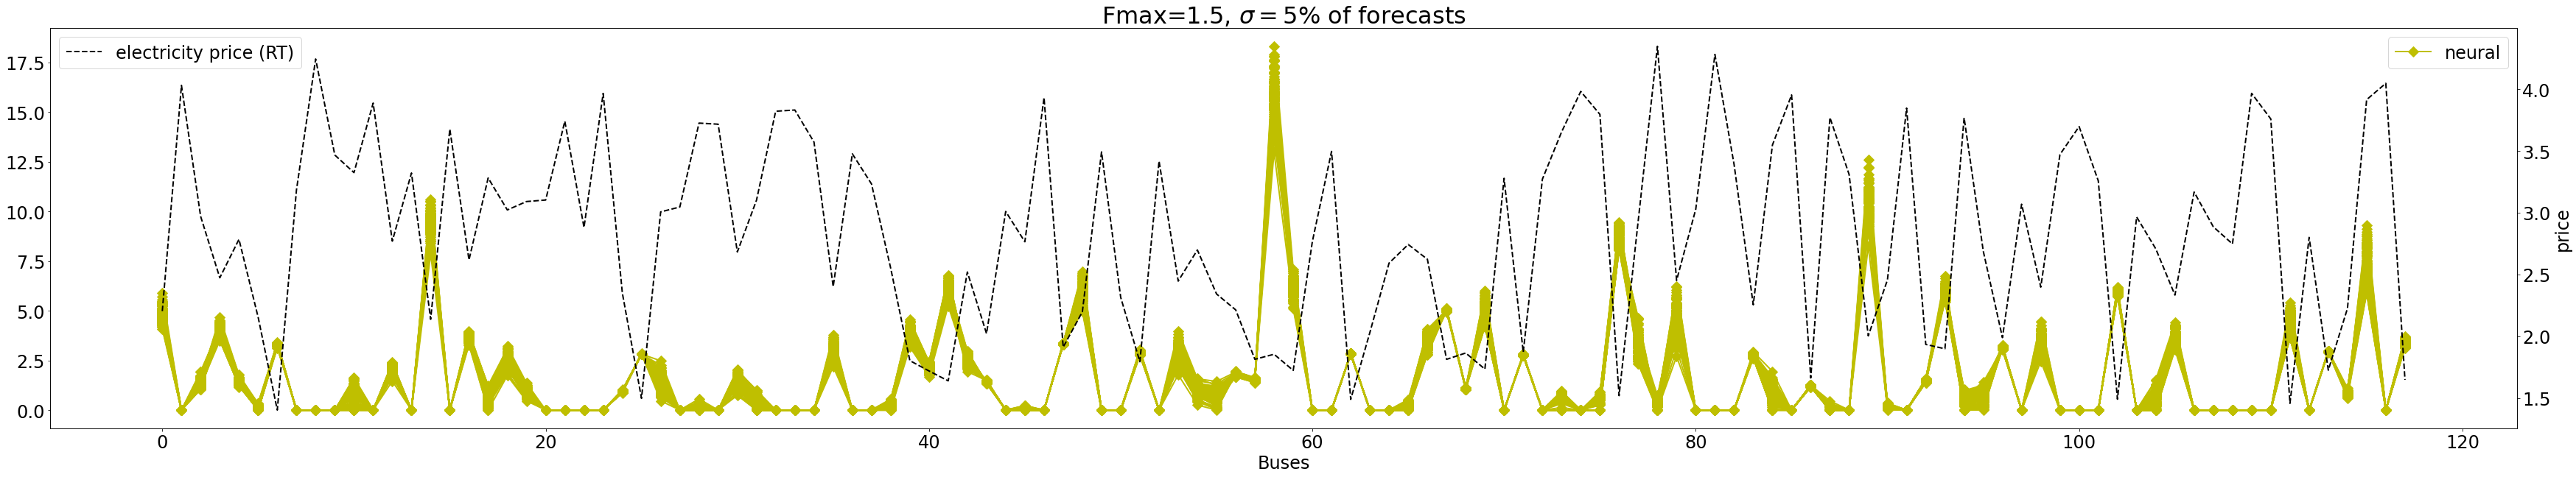

In [ ]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntst
for i in range(N_points):
    if i == 0:
        ax0.plot(Xrange, x_nu[i,:], 'y-D', markersize=10, linewidth=2, label='neural')

    else:
        ax0.plot(Xrange, x_nu[i,:], 'y-D', markersize=10, linewidth=2)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24, loc='upper left')


plt.show()

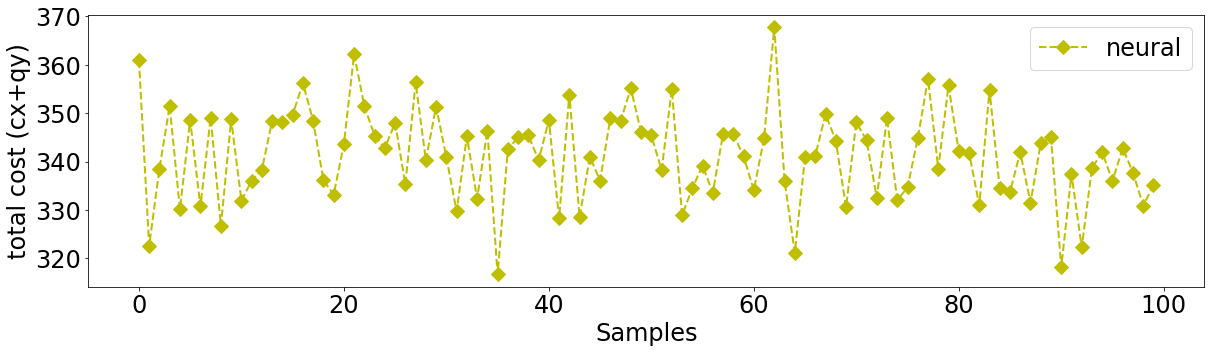

In [ ]:
fig = plt.figure(figsize=(20,5))
Xrange = np.array(range(Ntst))
plt.plot(Xrange, total_cost_nu.flatten(), 'y--D', markersize=10, linewidth=2, label='neural')
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total cost (cx+qy)', fontsize=24)

plt.show()

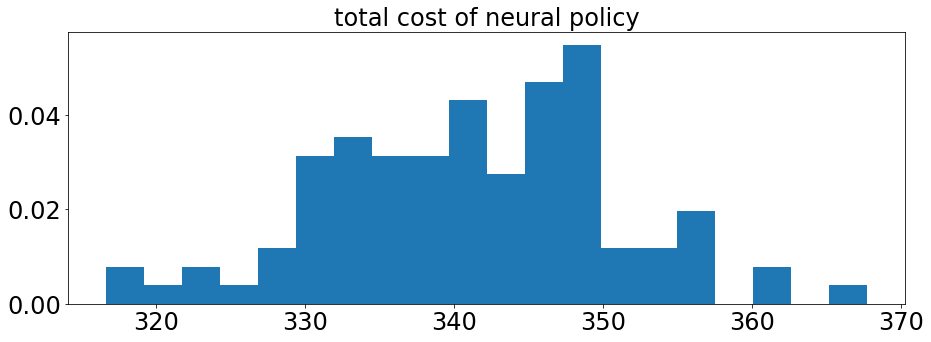

In [ ]:
fig, ax0 = plt.subplots(figsize=(15,5))
Xrange = np.array(range(N))

n_bins = 20
ax0.hist(total_cost_nu.flatten(), bins=n_bins, density=True)

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'total cost of neural policy', fontsize=24, color='k' )
plt.show()


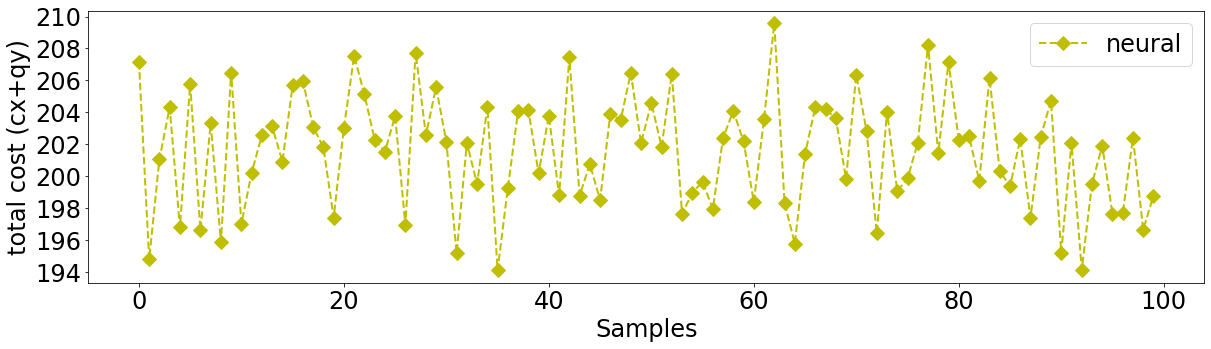

In [ ]:
fig = plt.figure(figsize=(20,5))
Xrange = np.array(range(Ntst))
plt.plot(Xrange, np.sum(x_nu, axis=-1), 'y--D', markersize=10, linewidth=2, label='neural')
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total cost (cx+qy)', fontsize=24)

plt.show()

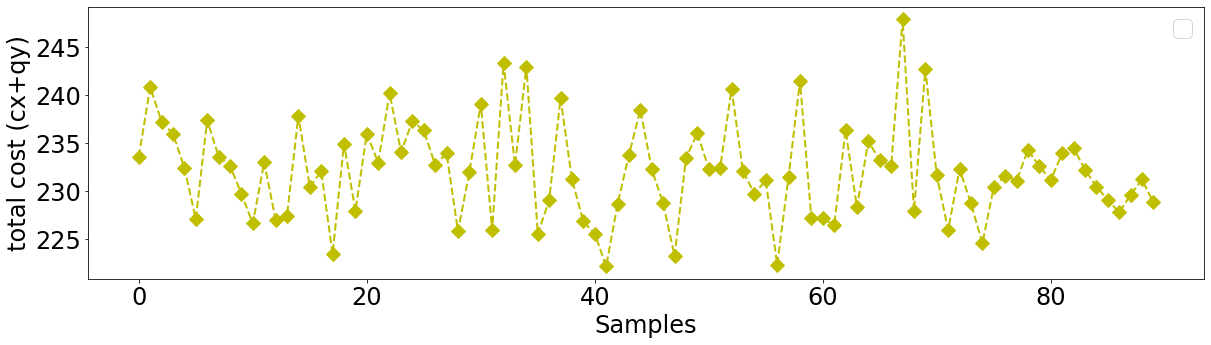

In [ ]:
fig = plt.figure(figsize=(20,5))
Xrange = np.array(range(X_train.shape[0]))
plt.plot(Xrange, np.sum(X_train[:,N:N+N], axis=-1)*max_PD_tr, 'y--D', markersize=10, linewidth=2)
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total cost (cx+qy)', fontsize=24)

plt.show()